In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from itertools import cycle
from patsy import dmatrices
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV,ElasticNet,enet_path,Lasso,LassoCV,lasso_path
from sklearn.datasets import make_regression
from redcap import Project
wd = '/Volumes/PEDS/RI Biostatistics Core/Shared/Shared Projects/Laura/Peds Endo/Petter Bjornstad/Renal Imaging/'

In [2]:
# # Import data from REDCap
# api_url = 'https://redcap.ucdenver.edu/api/'
# api_key = ''
# project = Project(api_url, api_key)
# data = project.export_records(forms=['parent_demographics'])

In [3]:
# Import data
df = pd.read_csv(wd + 'Data_Raw/177844RenalBloodFlow_DATA_2021-12-15_0836.csv')
# Predictors
r_rbf_avg = df[['r_rbf_avg_sr','r_rbf_avg_sup_sr','r_rbf_avg_inf_sr','r_rbf_avg_3b_sr']].sum(axis=1)
r_rbf_avg[r_rbf_avg == 0] = np.nan
r_rbf_avg_vein = df[['r_rbf_avg_vein_sr','r_rbf_avg_vein_sup_sr','r_rbf_avg_vein_inf_sr']].sum(axis=1)
r_rbf_avg_vein[r_rbf_avg_vein == 0] = np.nan
l_rbf_avg = df[['l_rbf_avg_sr','l_rbf_avg_sup_sr','l_rbf_avg_inf_sr','l_rbf_avg_3b_sr']].sum(axis=1)
l_rbf_avg[l_rbf_avg == 0] = np.nan
l_rbf_avg_vein = df[['l_rbf_avg_vein_sr','l_rbf_avg_vein_sup_sr','l_rbf_avg_vein_inf_sr']].sum(axis=1)
l_rbf_avg_vein[l_rbf_avg_vein == 0] = np.nan
r_rbf_peak = df[['r_rbf_peak_sr','r_rbf_peak_sup_sr','r_rbf_peak_inf_sr','r_rbf_peak_3b_sr']].sum(axis=1)
r_rbf_peak[r_rbf_peak == 0] = np.nan
r_rbf_peak_vein = df[['r_rbf_peak_vein_sr','r_rbf_peak_vein_sup_sr','r_rbf_peak_vein_inf_sr']].sum(axis=1)
r_rbf_peak_vein[r_rbf_peak_vein == 0] = np.nan
l_rbf_peak = df[['l_rbf_peak_sr','l_rbf_peak_sup_sr','l_rbf_peak_inf_sr','l_rbf_peak_3b_sr']].sum(axis=1)
l_rbf_peak[l_rbf_peak == 0] = np.nan
l_rbf_peak_vein = df[['l_rbf_peak_vein_sr','l_rbf_peak_vein_sup_sr','l_rbf_peak_vein_inf_sr']].sum(axis=1)
l_rbf_peak_vein[l_rbf_peak_vein == 0] = np.nan
r_rbv_peak = df[['r_rbv_peak_sr','r_rbv_peak_sup_sr','r_rbv_peak_inf_sr','r_rbv_peak_3b_sr']].sum(axis=1)
r_rbv_peak[r_rbv_peak == 0] = np.nan
r_rbv_peak_vein = df[['r_rbv_peak_vein_sr','r_rbv_peak_vein_sup_sr','r_rbv_peak_vein_inf_sr']].sum(axis=1)
r_rbv_peak_vein[r_rbv_peak_vein == 0] = np.nan
l_rbv_peak = df[['l_rbv_peak_sr','l_rbv_peak_sup_sr','l_rbv_peak_inf_sr','l_rbv_peak_3b_sr']].sum(axis=1)
l_rbv_peak[l_rbv_peak == 0] = np.nan
l_rbv_peak_vein = df[['l_rbv_peak_vein_sr','l_rbv_peak_vein_sup_sr','l_rbv_peak_vein_inf_sr']].sum(axis=1)
l_rbv_peak_vein[l_rbv_peak_vein == 0] = np.nan
# eGFR
eGFR_schwartz = round(0.413*(df.ht/df.screat),2)
# Put together
calculated = {'r_rbf_avg':r_rbf_avg,'r_rbf_avg_vein':r_rbf_avg_vein,'l_rbf_avg':l_rbf_avg,
              'l_rbf_avg_vein':l_rbf_avg_vein,'r_rbf_peak':r_rbf_peak,'r_rbf_peak_vein':r_rbf_peak_vein,
             'l_rbf_peak':l_rbf_peak,'l_rbf_peak_vein':l_rbf_peak_vein,'r_rbv_peak':r_rbv_peak,
              'r_rbv_peak_vein':r_rbv_peak_vein,'l_rbv_peak':l_rbv_peak,'l_rbv_peak_vein':l_rbv_peak_vein,
             'eGFR_schwartz':eGFR_schwartz}
calc_df = pd.concat(calculated,axis=1)
# Add other columns
final_df = pd.concat([df[['hr_mri_sr','hr_mri_rv_sr','hr_mri_la_sr','hr_mri_lv_sr',
                         'a1_peak_flow_sr','a1_max_vel_sr','a1_avg_vol_sr','a2_peak_flow_sr','a2_max_vel_sr','a2_avg_flow_sr']],calc_df,
               df[['igfr','igfr_ab']]],axis=1)
# Averages
final_df['rbf_avg'] = final_df[['r_rbf_avg','l_rbf_avg']].mean(axis=1)
final_df['rbf_avg_vein'] = final_df[['r_rbf_avg_vein','l_rbf_avg_vein']].mean(axis=1)
final_df['rbf_peak'] = final_df[['r_rbf_peak','l_rbf_peak']].mean(axis=1)
final_df['rbf_peak_vein'] = final_df[['r_rbf_peak_vein','l_rbf_peak_vein']].mean(axis=1)
final_df['rbv_peak'] = final_df[['r_rbv_peak','l_rbv_peak']].mean(axis=1)
final_df['rbv_peak_vein'] = final_df[['r_rbv_peak_vein','l_rbv_peak_vein']].mean(axis=1)
final_df.drop(columns = ['r_rbf_avg','l_rbf_avg','r_rbf_avg_vein','l_rbf_avg_vein',
                         'r_rbf_peak','l_rbf_peak','r_rbf_peak_vein','l_rbf_peak_vein',
                         'r_rbv_peak','l_rbv_peak','r_rbv_peak_vein','l_rbv_peak_vein'],inplace=True)
# List y and X variables
outcomes = ['igfr','igfr_ab','eGFR_schwartz']
pred = [c for c in final_df.columns if c not in outcomes]
# Write cleaned data
final_df.to_csv('/Volumes/PEDS/RI Biostatistics Core/Shared/Shared Projects/Laura/Peds Endo/Petter Bjornstad/Renal Imaging/Data_Clean/analysis_dataset.csv',index=False)

# IGFR

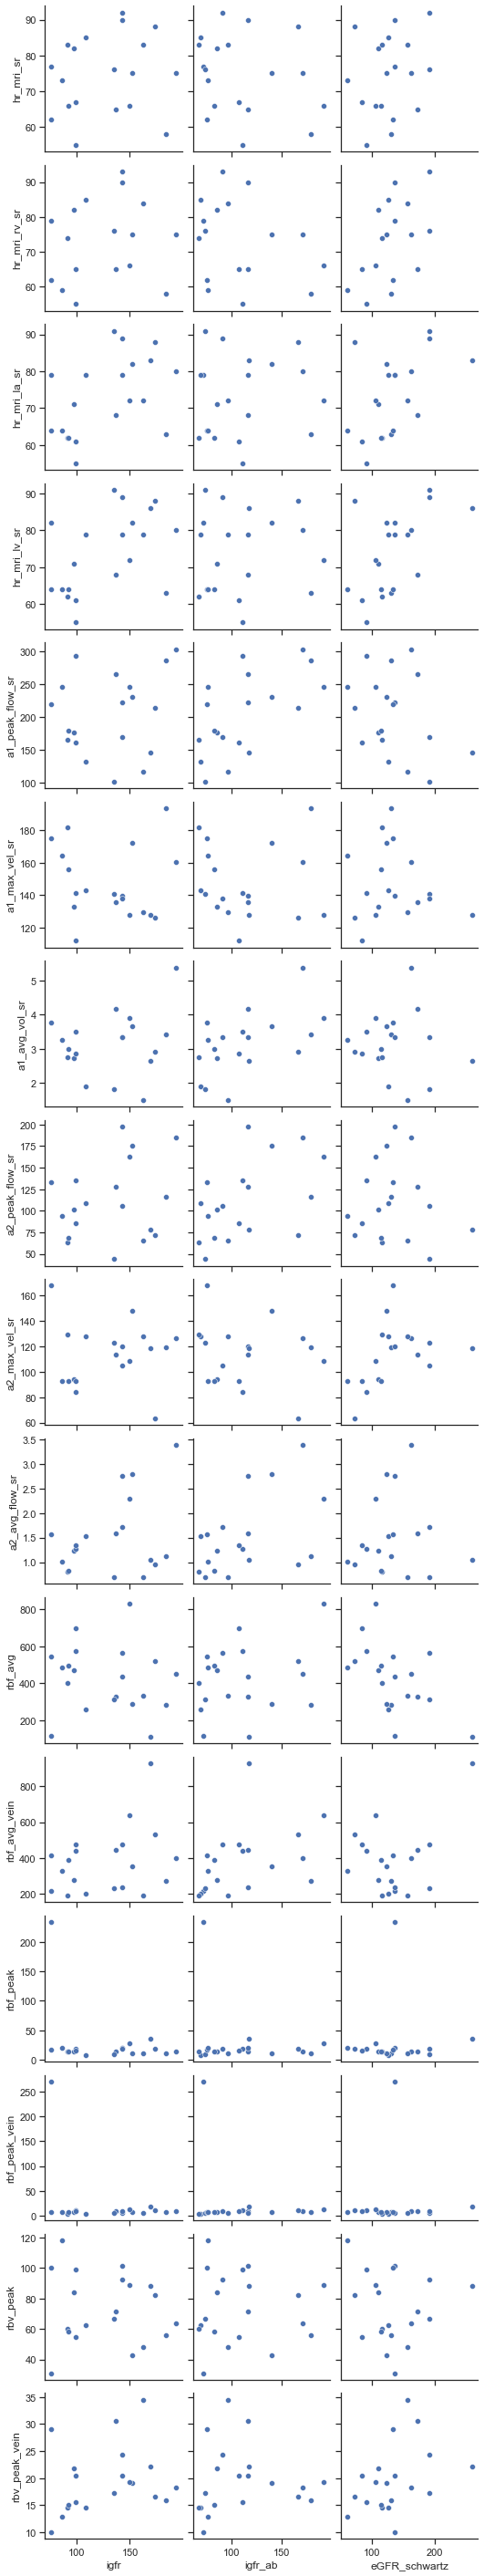

In [4]:
sns.set_theme(style="ticks")
sns.pairplot(final_df,x_vars=outcomes,y_vars=pred);

## ElasticNet

In [5]:
# Model matrices
y,X = dmatrices('igfr~'+'+'.join(pred),data=final_df)
# Scale X
# X.iloc[:,1:] = X.iloc[:,1:]/X.iloc[:,1:].std(0)
# LOO CV 
regr = LassoCV(cv=X.shape[0],max_iter=10000)
# ElasticNet CV
regr = regr.fit(X, y.ravel())
# Get alpha following 1SE rule
mse = regr.mse_path_
# Average CV error for each alpha value
m = pd.DataFrame(mse).mean(axis=1)
# SE of the average error
se = m.sem()
mm = m.min()
# Max allowable error
max_err = mm + se
# Get highest alpha (most shrinkage) within 1SE of minimum
a = regr.alphas_[np.where(m <= max_err)[0][0]]
# Re-fit with optimized params
# model = ElasticNet(alpha=regr.alpha_, l1_ratio=regr.l1_ratio_)
model = Lasso(alpha=a)
fit = model.fit(X, y)

### Regularization Paths

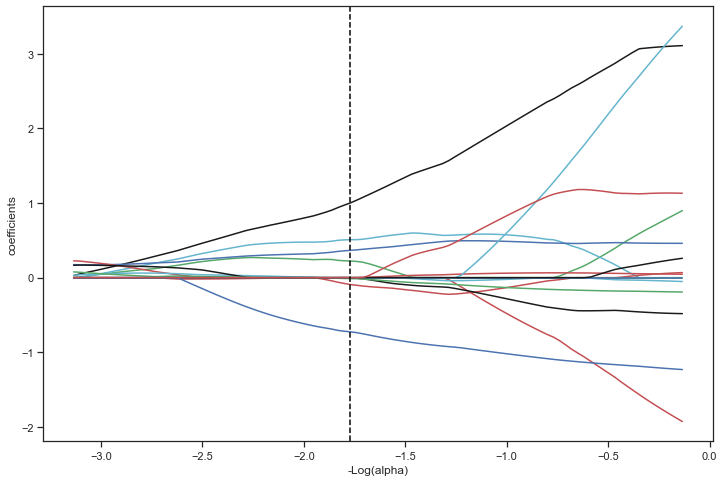

In [6]:
alphas, coefs, _ = fit.path(X, y, alphas=regr.alphas_,max_iter=10000)
# Plot 
plt.rcParams['figure.figsize'] = [12, 8]
plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas = -np.log10(alphas)
for coef, c in zip(coefs[0], colors):
    l2 = plt.plot(neg_log_alphas, coef, c=c)
plt.axvline(x = -np.log10(fit.alpha),color = 'black',linestyle = '--')
plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.axis("tight");

Regularization techniques like the lasso or ElasticNet select regression models by shrinking unimportant model coefficients to 0. The parameter alpha controls the amount of shrinkage applied to the model coefficients, and the optimal lambda was selected using leave-one-out (LOO) cross validation (CV). The dashed line in the above plot indicates the alpha value selected for this outcome (alpha values are negative log transformed here for better looking plots).

### Selected Variables

In [7]:
idx = [i - 1 for i in list(np.where(fit.coef_ != 0)[0])]
selected = [pred[i] for i in idx]
selected

['hr_mri_lv_sr', 'a1_peak_flow_sr', 'rbf_avg_vein', 'rbv_peak']

### Final Model

In [8]:
# Model matrices
y,X = dmatrices('igfr~'+'+'.join(selected),data=final_df,return_type="dataframe")
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   igfr   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     11.29
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           0.000264
Time:                        09:47:11   Log-Likelihood:                -81.006
No. Observations:                  19   AIC:                             172.0
Df Residuals:                      14   BIC:                             176.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -95.6157     47.223     -2.025      0.062    -196.898       5.667
hr_mri_lv_sr        2.6197      0.488      5.372      0.000       1.574       3.666
a1_peak_flow_sr     0.3732      0.090      4.159      0.001       0.181       0.566
rbf_avg_vein        0.0367      0.028      1.308      0.212      -0.024       0.097
rbv_peak           -0.7447      0.243     -3.070      0.008      -1.265      -0.224
==============================================================================
Omnibus:                        3.117   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                1.421
Skew:                           0.608   Prob(JB):                        0.491
Kurtosis:                       3.561   Cond. No.                     4.94e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Random Forest

In [9]:
rf = RandomForestRegressor(max_features=None,max_depth=None,n_jobs=8)
rf = rf.fit(X, np.array(y).ravel())

Petter's FAS code:

In [10]:
# * FAS combined equation, valid for all ages, serumcreat in mg/dL, serumcyst in mg/L, qcr from Pottel reference Table 1 in mg/dL,sex=1 female and sex=2 boys;




# data SUA.casperheirv2;
# set SUA.casperheirv2;



# alpha=0.5;
# if age_current=11 then qcr=0.53;
# if age_current=12 then qcr=0.57;
# if age_current=13 then qcr=0.59;
# if age_current=14 then qcr=0.61;
# if age_current=15 then do; if gender=0 then qcr=0.64; if gender=1 then qcr=0.72; end;
# if age_current=16 then do; if gender=0 then qcr=0.67; if gender=1 then qcr=0.78; end;
# if age_current=17 then do; if gender=0 then qcr=0.69; if gender=1 then qcr=0.82; end;
# if age_current=18 then do; if gender=0 then qcr=0.69; if gender=1 then qcr=0.85; end;
# if age_current=19 then do; if gender=0 then qcr=0.70; if gender=1 then qcr=0.88; end;
# if age_current >=20 then do; if gender=0 then qcr=0.70; if gender=1 then qcr=0.90; end;



# f1 = serum_creatinine/qcr;

# f2 = 1-alpha;



# f3 = cystatin_c/0.82;

# eGFR_cr = 107.3 / f1;
# eGFR_comb = 107.3 / ((alpha*f1) + (f2*f3));



# run;